In [ ]:
!pip install torch

In [2]:
import numpy as np
from math import sqrt
import torch
import pandas as pd
import torch.nn.functional as F
import random
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', **{'family': 'DejaVu Sans', 'size'   : 16})
matplotlib.rc('figure', figsize=(15, 7.5))

In [3]:
use_toy_problem = False  # use toy problem or real dataset
K = 32  # num latent features for U and V
train_frac = 0.7  # fraction of R to use as train vs val
num_epochs = 100
lr = 0.25  # learning rate
'''
4 models: 
    1. From-scratch linear: 'scratch-linear'
    2. Pytorch linear: 'pytorch-linear'
    3. Pytorch non-linear (simple): 'pytorch-nonlinear-simple'
    4. Pytorch non-linear (complex): 'pytorch-nonlinear-complex'
''' 
# Running multiple models will plot the performance on the same plot
model_definitions = ['pytorch-nonlinear-complex']  # can specify multiple models
run_all_models = True  # or can just set this to True to run all models

In [4]:
"""
Toy problem
- Underlying model: Each item has a feature of is action, is comedy, is rated R, is big-budget

Item 1: action, rated R
Item 2: action, comedy, rated R, big-budget
Item 3: comedy, big-budget
Item 4: big-budget
"""
def make_toy_data():
    R = np.array([
        [4, 4, 3, 4],  # likes action, dislikes comedy, likes big-budget
        [1, 2, 3, 2],  # likes comedy, dislikes action, dislikes R, dislikes big-budget
        [4, 4, 3, 3],  # likes R
        [4, 4, 3, 2],  # likes action, likes comedy, dislikes big-budget
        [2, 4, 5, 4],  # dislikes action, likes comedy, likes big-budget
    ], dtype=np.float32)
    return R

In [5]:
def get_dataset(use_toy_problem):
    if use_toy_problem:
        return make_toy_data()
    # ow Movie lens dataset, made smaller
    df = pd.read_csv('ratings.csv').astype(int)
    num_users = len(df.userId.unique())
    num_items = len(df.movieId.unique())
    user_df_dict = dict(zip(df.userId.unique(), list(range(num_users))))
    items_df_dict = dict(zip(df.movieId.unique(), list(range(num_items))))
    R = np.full((num_users, num_items), np.nan, dtype=np.float32)
    for indx, df_row in df.iterrows():
        R[user_df_dict[df_row.userId], items_df_dict[df_row.movieId]] = float(df_row.rating)
    # Make R smaller if you want
#     R = R[:, :610]
    return R

In [6]:
# Get/make dataset
R = get_dataset(use_toy_problem)
num_users, num_items = R.shape

In [7]:
def make_train_and_val_splits(R, num_rows, num_cols, train_frac):
    nan_full = lambda: np.full((num_rows, num_cols), np.nan)
    R_train, R_val = nan_full(), nan_full()
    did_train, did_val = False, False
    for row in range(num_rows):
        for col in range(num_cols):
            if np.random.random() < train_frac:
                R_train[row, col] = R[row, col]
                did_train = True
            else:
                R_val[row, col] = R[row, col]
                did_val = True
    assert did_train and did_val
    return R_train, R_val

In [8]:
# Make train/val splits
R_train, R_val = make_train_and_val_splits(R, num_users, num_items, train_frac)

In [9]:
def convert_tensor_to_np(t):
    if not torch.is_tensor(t):
        return t
    return t.detach().numpy()

In [10]:
class MatrixFactorizationLinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.is_linear = True
    
    def forward(self):
        raise NotImplementedError()
    
    def calculate_loss(self, R, R_hat):
        raise NotImplementedError()
    
    def optimize(self, loss, R, R_hat, N):
        raise NotImplementedError()
    
    @staticmethod
    def mask_out_nans(R, R_hat):
        lib = np if isinstance(R, np.ndarray) else torch
        R_mask = lib.isnan(R)
        R[R_mask] = R_hat[R_mask]
        N = (R.shape[0] * R.shape[1]) - R_mask.sum()
        return R, N

In [11]:
class MatrixFactorizationCustomLinearModel(MatrixFactorizationLinearModel):
    def __init__(self, num_users, num_items, K, lr):
        super().__init__()
        self.lr = lr
        self.U = MatrixFactorizationCustomLinearModel.xavier_uniform_array((num_users, K))
        self.V = MatrixFactorizationCustomLinearModel.xavier_uniform_array((num_items, K))
    
    @staticmethod
    def xavier_uniform_array(arr_shape):
        limit = sqrt(6. / sqrt(arr_shape[0] + arr_shape[1]))
        weights = np.random.uniform(-limit, limit, size=arr_shape)
        return weights
    
    def forward(self):
        return self.U @ self.V.T
        
    @staticmethod
    def _calc_mse(R, R_hat, N):
        return np.square(R - R_hat).sum() / N
    
    def calculate_loss(self, R, R_hat):
        # Mask out nans by setting to R_hat values
        R, N = MatrixFactorizationLinearModel.mask_out_nans(R, R_hat)
        # MSE and masked R
        loss = MatrixFactorizationCustomLinearModel._calc_mse(R, R_hat, N)
        return loss, loss, R, N
    
    @staticmethod
    def _calc_mse_gradient(R, R_hat, M, N):
        return (R - R_hat)@M * -2. / N
    
    def optimize(self, loss, R, R_hat, N):
        # Calc gradient of MSE for each factor matrix ie parameter
        # MSE grad
        U_grad = MatrixFactorizationCustomLinearModel._calc_mse_gradient(R, R_hat, self.V, N)
        V_grad = MatrixFactorizationCustomLinearModel._calc_mse_gradient(R.T, R_hat.T, self.U, N)
        # Update U and V based on gradient and step size
        self.U -= self.lr * U_grad
        self.V -= self.lr * V_grad

In [12]:
class MatrixFactorizationPytorchLinearModel(MatrixFactorizationLinearModel):
    def __init__(self, num_users, num_items, K, lr):
        super().__init__()
        self.U = torch.nn.Parameter(torch.zeros((num_users, K)))
        self.V = torch.nn.Parameter(torch.zeros((num_items, K)))
        torch.nn.init.xavier_uniform_(self.U)
        torch.nn.init.xavier_uniform_(self.V)
        
        self.MSE = torch.nn.MSELoss(reduction='sum')
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
    
    def forward(self):
        return self.U @ self.V.T
    
    def calculate_loss(self, R, R_hat):
        R = torch.tensor(R, dtype=torch.float)
        # Mask out nans by setting to R_hat values
        R, N = MatrixFactorizationLinearModel.mask_out_nans(R, R_hat)
        t_loss = self.MSE(R, R_hat) / N
        np_loss = convert_tensor_to_np(t_loss)
        return t_loss, np_loss, R, N
    
    def optimize(self, loss, R, R_hat, N):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [13]:
def train_linear_model(MF_model, R_train, R_val, num_epochs):
    train_losses, val_losses = [], []
    # Training
    for curr_epoch in range(num_epochs):
        # Train
        # Reconstruct R_hat from latent factor matrices
        R_hat = MF_model.forward()
        # Calc MSE loss of this reconstruction
        # And create a nan masked R_train for future use
        train_loss, np_train_loss, R_train_masked, N = MF_model.calculate_loss(R_train.copy(), R_hat)
        # Calc grad and update
        MF_model.optimize(train_loss, R_train_masked, R_hat, N)
        train_losses.append(np_train_loss)
        
        # Eval
        val_loss, np_val_loss, _, _ = MF_model.calculate_loss(R_val.copy(), R_hat)
        val_losses.append(np_val_loss)
        print(f'Epoch {curr_epoch+1} losses -> Train: {np_train_loss} - Val: {np_val_loss}')
        
    return train_losses, val_losses

In [14]:
class MatrixFactorizationPytorchNonLinearModel(torch.nn.Module):
    def __init__(self, num_users, num_items, K, lr):
        super().__init__()
        self.is_linear = False
        
        self.U_layer = torch.nn.Linear(num_users, K)
        torch.nn.init.xavier_uniform_(self.U_layer.weight)
        self.V_layer = torch.nn.Linear(num_items, K)
        torch.nn.init.xavier_uniform_(self.V_layer.weight)
        
        self.MSE = torch.nn.MSELoss()
    
    def forward(self, U_one_hots, V_one_hots):
        raise NotImplementedError()
    
    def calculate_loss(self, R, R_hat):
        t_loss = self.MSE(R, R_hat)
        np_loss = convert_tensor_to_np(t_loss)
        return t_loss, np_loss
    
    def optimize(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [15]:
class SimpleNonLinearModel(MatrixFactorizationPytorchNonLinearModel):
    def __init__(self, num_users, num_items, K, lr):
        super().__init__(num_users, num_items, K, lr)        
        self.fc1 = torch.nn.Linear(2 * K, K)
        self.fc2 = torch.nn.Linear(K, 1)
        
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        
    def forward(self, U_one_hots, V_one_hots):
        U_latent = self.U_layer(U_one_hots)
        V_latent = self.V_layer(V_one_hots)
        x = torch.cat((U_latent, V_latent), dim=1)
        # Non-linear transform
        x = torch.sigmoid(self.fc1(x))
        R_hat = self.fc2(x)
        return R_hat

In [16]:
class ComplexNonLinearModel(MatrixFactorizationPytorchNonLinearModel):
    def __init__(self, num_users, num_items, K, lr):
        super().__init__(num_users, num_items, K, lr) 
        drop_p = 0.25
        
        self.U_dropout = torch.nn.Dropout(p=drop_p)
        self.V_dropout = torch.nn.Dropout(p=drop_p)
        
        self.fc1 = torch.nn.Linear(2 * K, K)
        self.dropout1 = torch.nn.Dropout(p=drop_p)
        self.fc2 = torch.nn.Linear(K, K // 2)
        self.dropout2 = torch.nn.Dropout(p=drop_p)
        self.fc3 = torch.nn.Linear(K // 2, 1)
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
    def forward(self, U_one_hots, V_one_hots):
        U_latent = self.U_layer(U_one_hots)
        U_latent = self.U_dropout(U_latent)
        V_latent = self.V_layer(V_one_hots)
        V_latent = self.V_dropout(V_latent)
        x = torch.cat((U_latent, V_latent), dim=1)
        # Non-linear transform
        x = torch.sigmoid(self.fc1(x))
        x = self.dropout1(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.dropout2(x)
        R_hat = self.fc3(x)
        return R_hat

In [17]:
def create_inputs_and_targets(R, num_users, num_items):
    def create_one_hot(length, pos):
        one_hot = np.zeros(shape=(length,), dtype=np.float32)
        one_hot[pos] = 1.
        return one_hot
    # Inputs are one hot vectors
    U_one_hots, V_one_hots = [], []
    # Targets are flattened R without nans
    R_targets = []
    for row in range(num_users):
        row_one_hot = create_one_hot(num_users, row)
        for col in range(num_items):
            value = R[row, col]
            if not np.isnan(value):
                U_one_hots.append(row_one_hot)
                V_one_hots.append(create_one_hot(num_items, col))
                R_targets.append(value)
    return torch.tensor(U_one_hots),torch.tensor(V_one_hots), torch.tensor(R_targets, dtype=torch.float32).unsqueeze(1)

In [18]:
def train_nonlinear_model(MF_model, R_train, R_val, num_users, num_items, num_epochs):
    # Dont use matrices here as there can be a lot of "white space" in a sparse ranking matrix
    U_one_hots_train, V_one_hots_train, R_targets_train = create_inputs_and_targets(R_train, num_users, num_items)
    U_one_hots_val, V_one_hots_val, R_targets_val = create_inputs_and_targets(R_val, num_users, num_items)
    
    train_losses, val_losses = [], []
    # Training
    for curr_epoch in range(num_epochs):
        # Train
        MF_model.train()  # train mode
        # Reconstruct R_hat from latent factor matrices
        R_hat_train = MF_model.forward(U_one_hots_train, V_one_hots_train)
        # Calc MSE loss of this reconstruction
        train_loss, np_train_loss = MF_model.calculate_loss(R_targets_train, R_hat_train)
        # Calc grad and update
        MF_model.optimize(train_loss)
        train_losses.append(np_train_loss)
        
        # Eval
        MF_model.eval()  # eval mode
        R_hat_val = MF_model.forward(U_one_hots_val, V_one_hots_val)
        val_loss, np_val_loss = MF_model.calculate_loss(R_targets_val, R_hat_val)
        val_losses.append(np_val_loss)
        print(f'Epoch {curr_epoch+1} losses -> Train: {np_train_loss} - Val: {np_val_loss}')
        
    return train_losses, val_losses

In [19]:
model_dict = {'scratch-linear': MatrixFactorizationCustomLinearModel, 
              'pytorch-linear': MatrixFactorizationPytorchLinearModel,
              'pytorch-nonlinear-simple': SimpleNonLinearModel, 
              'pytorch-nonlinear-complex': ComplexNonLinearModel}

In [20]:
def train_model(model_definition, performance_dict):
    model = model_dict[model_definition](num_users, num_items, K, lr)
    print(f'Training {model_definition} model...')
    if model.is_linear:
        train_losses, val_losses = train_linear_model(model, R_train, R_val, num_epochs)
    else:
        train_losses, val_losses = \
            train_nonlinear_model(model, R_train, R_val, num_users, num_items, num_epochs)
    print('...completed training\n')
    performance_dict[model_definition] = (train_losses, val_losses)

In [21]:
def train_models():
    performance_dict = OrderedDict()
    # Run all models, or only the specified models
    model_list = list(model_dict.keys()) if run_all_models else model_definitions
    for model_definition in model_list:
        train_model(model_definition, performance_dict)
    return performance_dict

In [22]:
# Make and train model(s)
performance_dict = train_models()

Training scratch-linear model...
Epoch 1 losses -> Train: 12.455331551069099 - Val: 12.505968791204277
Epoch 2 losses -> Train: 12.454730848274464 - Val: 12.5059420468049
Epoch 3 losses -> Train: 12.454130353823178 - Val: 12.505915359168483
Epoch 4 losses -> Train: 12.453530064073846 - Val: 12.50588872539664
Epoch 5 losses -> Train: 12.45292997538864 - Val: 12.505862142593243
Epoch 6 losses -> Train: 12.452330084133216 - Val: 12.505835607864588
Epoch 7 losses -> Train: 12.451730386676651 - Val: 12.505809118319206
Epoch 8 losses -> Train: 12.451130879391334 - Val: 12.505782671067795
Epoch 9 losses -> Train: 12.450531558652894 - Val: 12.505756263223164
Epoch 10 losses -> Train: 12.449932420840126 - Val: 12.505729891900081
Epoch 11 losses -> Train: 12.44933346233483 - Val: 12.505703554215359
Epoch 12 losses -> Train: 12.448734679521907 - Val: 12.505677247287561
Epoch 13 losses -> Train: 12.448136068789056 - Val: 12.505650968237196
Epoch 14 losses -> Train: 12.447537626526842 - Val: 12.505

C:\Users\nicol\AppData\Local\Temp\ipykernel_37156\502854005.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(U_one_hots),torch.tensor(V_one_hots), torch.tensor(R_targets, dtype=torch.float32).unsqueeze(1)


Epoch 1 losses -> Train: 12.868693351745605 - Val: 155.80650329589844
Epoch 2 losses -> Train: 156.03485107421875 - Val: 344.8682861328125
Epoch 3 losses -> Train: 344.53045654296875 - Val: 3.583681344985962
Epoch 4 losses -> Train: 3.624011516571045 - Val: 1.7720574140548706
Epoch 5 losses -> Train: 1.79884672164917 - Val: 1.3225371837615967
Epoch 6 losses -> Train: 1.3425558805465698 - Val: 1.2118498086929321
Epoch 7 losses -> Train: 1.228482961654663 - Val: 1.185024380683899
Epoch 8 losses -> Train: 1.1999648809432983 - Val: 1.1787409782409668
Epoch 9 losses -> Train: 1.1928352117538452 - Val: 1.1773817539215088
Epoch 10 losses -> Train: 1.1910529136657715 - Val: 1.1771478652954102
Epoch 11 losses -> Train: 1.1906071901321411 - Val: 1.1771422624588013
Epoch 12 losses -> Train: 1.1904959678649902 - Val: 1.177167296409607
Epoch 13 losses -> Train: 1.1904679536819458 - Val: 1.1771868467330933
Epoch 14 losses -> Train: 1.1904610395431519 - Val: 1.1771982908248901
Epoch 15 losses -> Trai

In [23]:
def plot_performance(performance_dict, save_file='performance.png'):
    fig, ax = plt.subplots()
    for model_name, (train_losses, val_losses) in list(performance_dict.items()):
        epochs = list(range(1, len(train_losses)+1))
        ax.plot(epochs, val_losses, label=model_name, linewidth=3)
    plt.xlabel('epoch')
    plt.ylabel('val loss')
    plt.xlim(0)
    plt.ylim(0, 15)
    
    plt.xticks([1] + list(range(10, 100, 10))+[100])
    
    plt.yticks([0, 1, 3, 5, 7, 9, 11, 13, 15])
    
    plt.legend()
    plt.grid()
    plt.title('Val Loss by Epoch of MF Models')
    fig.savefig(save_file)
    plt.show()

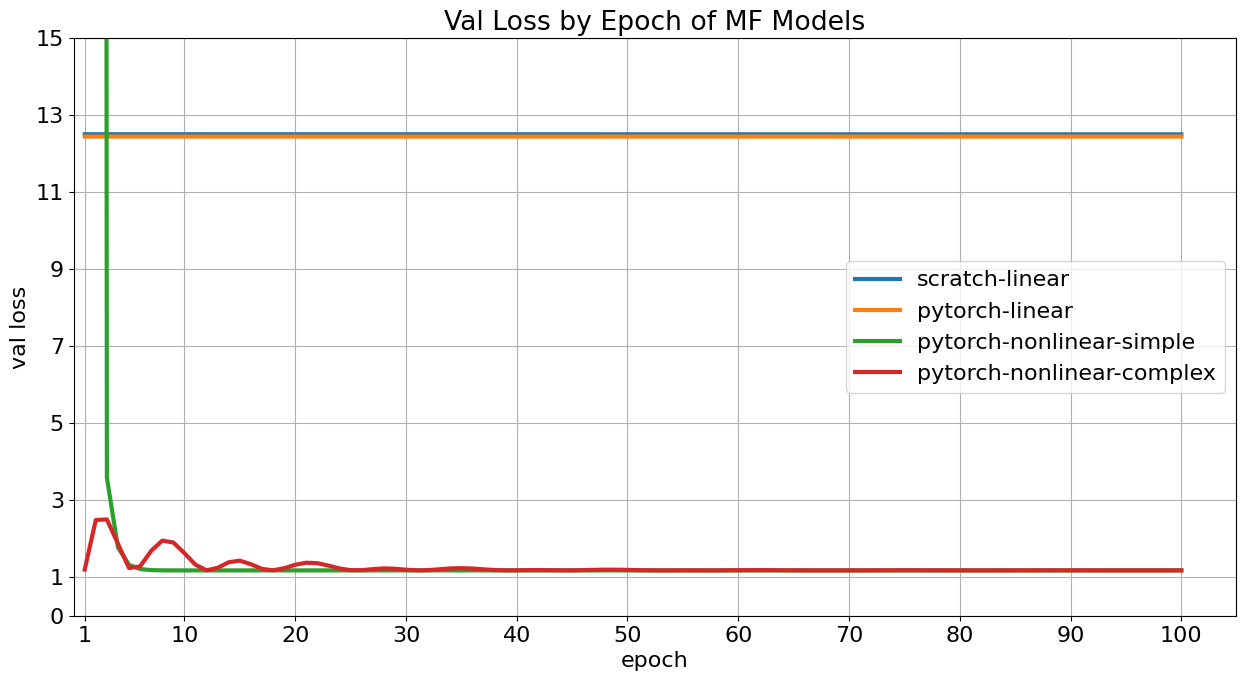

In [24]:
plot_performance(performance_dict)